In [35]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset
from datetime import datetime
import matplotlib.pyplot as plt
import cmocean

In [24]:
def read_nc_variable(fname, var_name):
    with Dataset(fname, 'r') as ds:
        return ds[var_name][:]

fname = './glider_data/unit_334_delayed_trajectory.nc'

# Define the mapping for the variable names and their paths in the .nc file
variables = {
    "time": "time",
    "temp": "temperature",
    "salt": "salinity",
    "pres": "pressure",
    "cond": "conductivity",
    "depth": "depth",
    "chla": "chlorophyll_a",
    "bb700": "/glider_record/sci_flbb_bb_units",
    "lon": "lon_qc",
    "lat": "lat_qc",
    "prof_time": "profile_time",
    "prof_idx": "profile_index",
    "prof_dir": "profile_direction",
    "m_depth": "glider_record/m_depth",
    "x_dr_state": "glider_record/x_dr_state",
    "u_dac": "u",
    "v_dac": "v",
    "m_heading": "glider_record/m_heading",
    "m_roll": "glider_record/m_roll",
    "m_pitch": "glider_record/m_pitch",
    "water_depth": "glider_record/m_water_depth"
}

gdat = {}
for key, path in variables.items():
    gdat[key] = read_nc_variable(fname, path)
    if isinstance(gdat[key], np.ma.MaskedArray):
        gdat[key] = gdat[key].filled(np.nan)


# Convert time to datetime object
gdat['timeDateNum'] = [datetime.utcfromtimestamp(time) for time in gdat['time']]

In [25]:
# Some basic data QC
# Apply conditions and replace values with NaN
gdat['cond'][gdat['cond'] < 1] = np.nan
gdat['salt'][gdat['salt'] < 10] = np.nan
gdat['temp'][gdat['temp'] == 0] = np.nan

In [26]:
# interpolate 
nearest_interpolation_vars = ['x_dr_state', 'prof_idx','prof_dir']
from scipy import interpolate


for var in nearest_interpolation_vars:
    # If the data is a masked array, convert it to a numpy array filled with NaN for masked values
    if isinstance(gdat[var], np.ma.MaskedArray):
        gdat[var] = gdat[var].filled(np.nan)
    
    idnan = ~np.isnan(gdat[var])
    
    if var in nearest_interpolation_vars:
        f = interpolate.interp1d(gdat['time'][idnan], gdat[var][idnan], kind='nearest', fill_value="extrapolate", bounds_error=False)
        gdat[var] = f(gdat['time'])
    else:
        # This is for linear interpolation
        gdat[var] = np.interp(gdat['time'], gdat['time'][idnan], gdat[var][idnan])

In [27]:
# Convert to DataFrame and process
df = pd.DataFrame(gdat)
df = df.drop_duplicates(subset='timeDateNum')

start_date = datetime(2023, 8, 24)
end_date = datetime(2023, 8, 29)
df = df[(df['timeDateNum'] >= start_date) & (df['timeDateNum'] <= end_date)]


In [64]:
import importlib
import custom_functions
importlib.reload(custom_functions)
from custom_functions import pgrid_columns, delete_almost_empty_columns

pg = np.arange(0, 201, 1)

# Grid the data
pg_chla ,_ = pgrid_columns(df.prof_idx, df.pres, df.chla, pg)
pg_bb700 ,_ = pgrid_columns(df.prof_idx, df.pres, df.bb700, pg)
pg_temp ,_ = pgrid_columns(df.prof_idx, df.pres, df.temp, pg)
pg_salt ,_ = pgrid_columns(df.prof_idx, df.pres, df.salt, pg)
pg_time ,_ = pgrid_columns(df.prof_idx, df.pres, df.time, pg) # unix epoch seconds 


pg_chla, cols2keep = delete_almost_empty_columns(pg_chla,pg)
pg_temp = pg_temp[:, cols2keep]
pg_salt = pg_salt[:, cols2keep]
pg_bb700 = pg_bb700[:, cols2keep]
pg_time = pg_time[:,cols2keep]

In [75]:
# Compute the mean of the timestamp grid along the desired axis (assuming axis=1 for your case)
mean_time_unix = np.nanmean(pg_time, axis=0)

# If you want to interpolate NaNs as you did in your MATLAB code:
idn = ~np.isnan(mean_time_unix)
timeg = np.interp(np.arange(len(mean_time_unix)), np.arange(len(mean_time_unix))[idn], mean_time_unix[idn])
timeg = pd.to_datetime(timeg, unit='s')


(73,)


(201, 73) (201, 73) (201, 73)


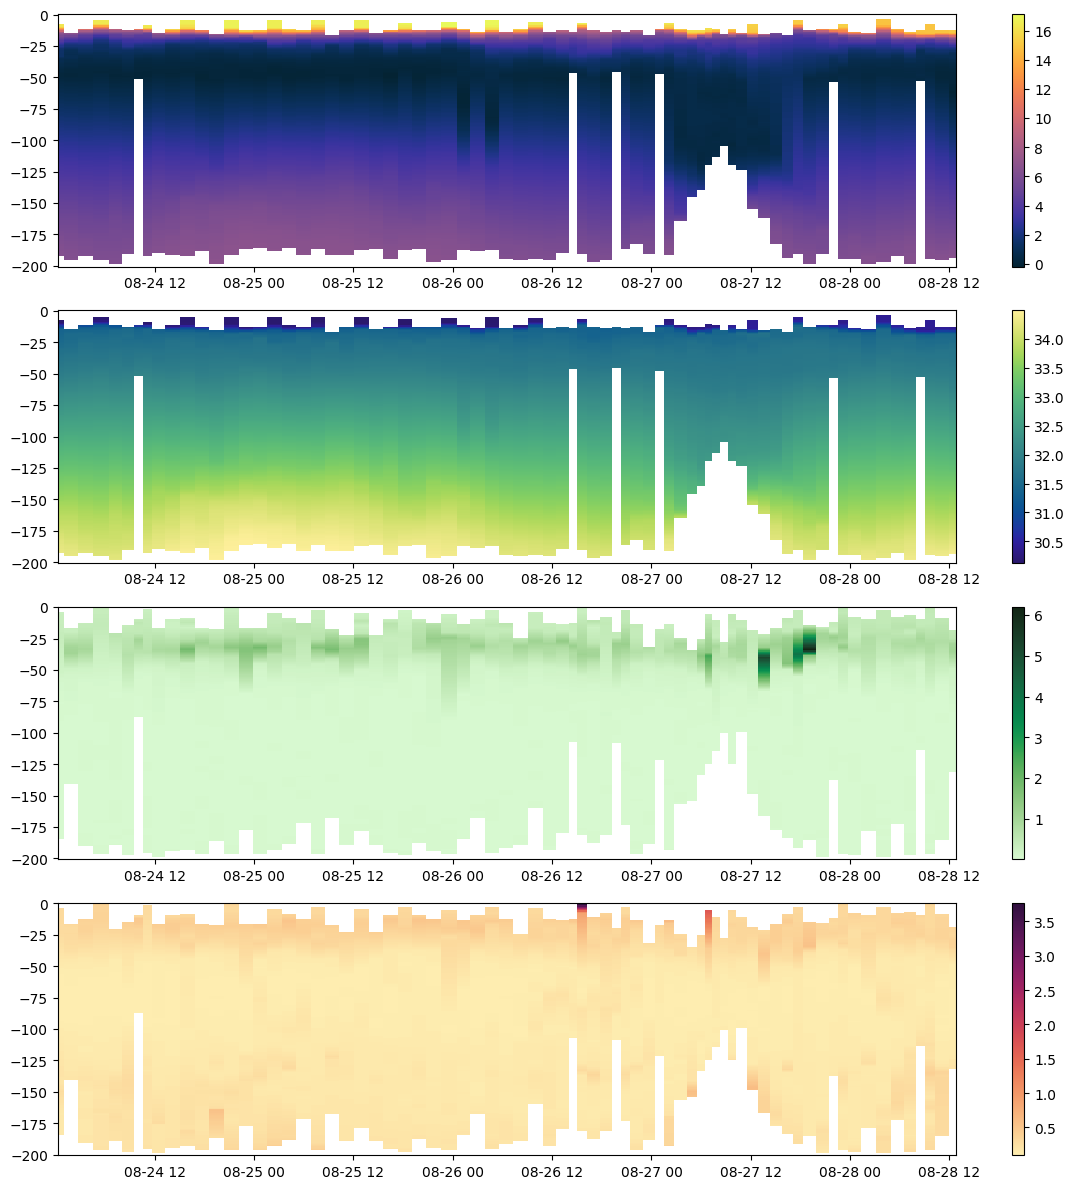

In [79]:
x, y = np.meshgrid(timeg, pg)
print(x.shape,y.shape,pg_temp.shape)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

# Plot Temperature
cax = ax[0].pcolormesh(x, -y, pg_temp, cmap=cmocean.cm.thermal)
ax[0].set_xlim([np.nanmin(timeg), np.nanmax(timeg)])
plt.colorbar(cax, ax=ax[0])  # This is how you add a colorbar

# Plot Salinity
cax = ax[1].pcolormesh(x, -y, pg_salt, cmap=cmocean.cm.haline)
ax[1].set_xlim([np.nanmin(timeg), np.nanmax(timeg)])
plt.colorbar(cax, ax=ax[1])  # This is how you add a colorbar


# Plot Chla
cax = ax[2].pcolormesh(x, -y, pg_chla, cmap=cmocean.cm.algae)
ax[2].set_xlim([np.nanmin(timeg), np.nanmax(timeg)])
plt.colorbar(cax, ax=ax[2])  # This is how you add a colorbar


# Plot bb700
cax = ax[3].pcolormesh(x, -y, pg_bb700*1e3, cmap=cmocean.cm.matter)
ax[3].set_xlim([np.nanmin(timeg), np.nanmax(timeg)])
plt.colorbar(cax, ax=ax[3])  # This is how you add a colorbar

plt.tight_layout()
plt.show()